# Spotify data study

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import imblearn
import sklearn

import sys
sys.path.append("../helpers")
import ploter

from importlib import reload
reload(ploter)

<module 'ploter' from '../helpers\\ploter.py'>

### 3 - Loading the data

In [138]:
BASE_PATH = "../my_spotify_data/StreamingHistory{}.json"

dfs = []

for i in range(5):
    dfs.append(pd.read_json(BASE_PATH.format(i)))
df = pd.concat(dfs)
df = df.reset_index(drop='True')

In [139]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-11-20 08:55,Rayland Baxter,Yellow Eyes,156074
1,2020-11-21 09:04,FloodCast,S06E04 - Deux Teufeurs Pas Purs,1465471
2,2020-11-21 12:53,Peter Bjorn and John,Young Folks,4800
3,2020-11-21 12:53,alt-J,Breezeblocks,5290
4,2020-11-21 12:57,Bibio,lovers’ carvings,238640


### 2 - EDA

understanding my data by spotify : https://support.spotify.com/us/article/understanding-my-data/

msPlayed : number of milliseconds during which the music was played

##### a) Deduce the start time and overal runtime

In [140]:
## translate to date and timedelta
df["endTime"] = pd.to_datetime(df.endTime) 
df["msPlayedDate"] = df.msPlayed.apply(lambda listening_time : pd.Timedelta(listening_time, unit="ms"))

## deduce start time
df["startTime"] = df.endTime - df.msPlayedDate

In [141]:
df[["startTime", "endTime", "msPlayedDate"]]

,startTime,endTime,msPlayedDate
0,2020-11-20 08:52:23.926,2020-11-20 08:55:00,0 days 00:02:36.074000
1,2020-11-21 08:39:34.529,2020-11-21 09:04:00,0 days 00:24:25.471000
2,2020-11-21 12:52:55.200,2020-11-21 12:53:00,0 days 00:00:04.800000
3,2020-11-21 12:52:54.710,2020-11-21 12:53:00,0 days 00:00:05.290000
4,2020-11-21 12:53:01.360,2020-11-21 12:57:00,0 days 00:03:58.640000
...,...,...,...
41280,2021-11-21 22:48:58.592,2021-11-21 22:49:00,0 days 00:00:01.408000
41281,2021-11-21 22:49:27.987,2021-11-21 22:53:00,0 days 00:03:32.013000
41282,2021-11-21 22:52:24.960,2021-11-21 22:57:00,0 days 00:04:35.040000
41283,2021-11-21 22:57:42.360,2021-11-21 23:01:00,0 days 00:03:17.640000


##### c) Listening time study 

In [142]:
df.msPlayed

0         156074
1        1465471
2           4800
3           5290
4         238640
          ...   
41280       1408
41281     212013
41282     275040
41283     197640
41284     121000
Name: msPlayed, Length: 41285, dtype: int64

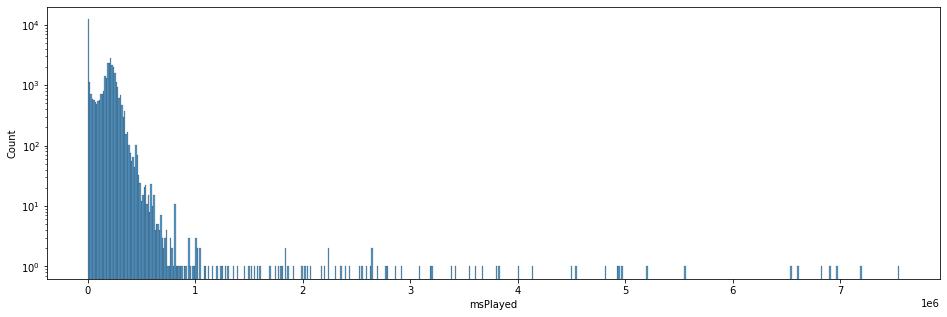

In [143]:
f = plt.figure(figsize=(16, 5))
g = sns.histplot(data=df, x="msPlayed")
g.set_yscale("log")

They are some weird max values , let's have a look at this :

In [144]:
## 10 longest listening
longest = np.argsort(df.msPlayed)[-30:]

df.iloc[longest]

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime
11174,2021-03-13 13:49:00,FloodCast,S06E07 - Burrito au Placenta,2785954,0 days 00:46:25.954000,2021-03-13 13:02:34.046
15530,2021-04-21 11:23:00,La Table Ovale,La Table Ovale de Mcfly et Carlito #2 - la ha...,2861441,0 days 00:47:41.441000,2021-04-21 10:35:18.559
16652,2021-05-03 11:55:00,FloodCast,S05E14 - Chernobyl du Bigdil,2918869,0 days 00:48:38.869000,2021-05-03 11:06:21.131
23585,2021-06-27 20:07:00,FloodCast,S06E14 - Origine Mytho,3087082,0 days 00:51:27.082000,2021-06-27 19:15:32.918
17700,2021-05-13 20:38:00,FloodCast,S06E12 - Colostomie Bugsy,3191381,0 days 00:53:11.381000,2021-05-13 19:44:48.619
15145,2021-04-15 11:29:00,FloodCast,S06E08 - Les Crocs de Michel Sardou,3201386,0 days 00:53:21.386000,2021-04-15 10:35:38.614
25991,2021-07-18 19:10:00,PARDON LE CINÉMA,"THE FATHER, PROMISING YOUNG MÉANDRE & SMALL SO...",3387431,0 days 00:56:27.431000,2021-07-18 18:13:32.569
2570,2020-12-16 14:10:00,Un Bon Moment avec Kyan KHOJANDI et NAVO,"avec FREDDY GLADIEUX, ANIS RHALI et AURELIEN P...",3429227,0 days 00:57:09.227000,2020-12-16 13:12:50.773
6562,2021-01-25 23:12:00,FloodCast,S06E06 - Donne ton sperme t'en as plein !,3550614,0 days 00:59:10.614000,2021-01-25 22:12:49.386
37495,2021-10-24 14:35:00,FloodCast,S07E04 - La Vengeance du Chasseur Landais,3604458,0 days 01:00:04.458000,2021-10-24 13:34:55.542


Ok well it's not really suprising that podcast are really longer than usual songs.
<ins>Good news is :</ins> I don't listen to much of them so we can retrieve it pretty simply. I listen to "FloodCast", "PARDON LE CINÉMA", "La Table Ovale", "Un Bon Moment avec Kyan KHOJANDI et NAVO", "We Love TFTC".

That's already labeled data. We will try to fit a **linear classification** between the msPlayed and the podcast. Should be quiet easy.

In [145]:
def is_known_podcast(artist, known_podcasters):
    return artist in known_podcasters

known_podcasters =  ["FloodCast", "PARDON LE CINÉMA", "La Table Ovale", "Un Bon Moment avec Kyan KHOJANDI et NAVO", "We Love TFTC"]
df["known_podcast"] = df.artistName.apply(lambda artist : is_known_podcast(artist, known_podcasters))
df["title_len"] = df.trackName.apply(len)

In [146]:
def normalize(X, mean, std):
    return (X - mean)/std

In [147]:
## select a balanced dataset
true_entry = df[df.known_podcast].sample(n=80)
false_entry = df[~df.known_podcast].sample(n=200)

data = pd.concat([true_entry, false_entry])
X, y = data[["title_len", "msPlayed"]].to_numpy(), data["known_podcast"].to_numpy()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

mu = X_train.mean(axis=0)
sig = X_train.std(axis=0)

In [148]:
## have to normalize due to magnitude difference between both features
X_train = normalize(X_train, mu, sig)
X_test = normalize(X_test, mu, sig)

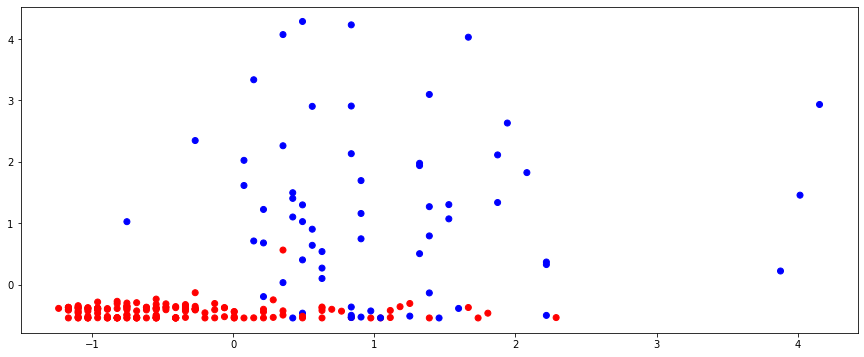

In [149]:
f = plt.figure(figsize=(15, 6))
colors = ["red" if x == 0 else "blue" for x in y_train]
plt.scatter(x=X_train[:,0], y=X_train[:,1], color=colors)

In [150]:
model = sklearn.svm.SVC(kernel='poly', C=0.1, degree=8, gamma=1.0, coef0=1.0).fit(X_train, y_train)

In [151]:
print(f"R square score for the model : {model.score(X_test, y_test)}") ## rather good R^2 value

R square score for the model : 0.8392857142857143


In [ ]:
### small cross val
ds = range(1, 15)
gs = range(1, 8, 3)
rss = np.zeros((len(ds), len(gs)))
for i, d in enumerate(ds):
    for j, g in enumerate(gs):
        print((i, j))
        rss[i, j] = sklearn.svm.SVC(kernel='poly', C=0.1, degree=d, gamma=g, coef0=1.0).fit(X_train, y_train).score(X_test, y_test)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
(3, 0)
(3, 1)
(3, 2)
(4, 0)
(4, 1)
(4, 2)
(5, 0)
(5, 1)
(5, 2)
(6, 0)
(6, 1)
(6, 2)
(7, 0)
(7, 1)
(7, 2)
(8, 0)
(8, 1)
(8, 2)
(9, 0)
(9, 1)
(9, 2)
(10, 0)
(10, 1)


In [152]:
model = sklearn.svm.SVC(kernel='poly', C=0.1, degree=2, gamma=3, coef0=1.0).fit(X_train, y_train)
print(f"R square score for the model : {model.score(X_test, y_test)}") ## rather good R^2 value

R square score for the model : 0.8392857142857143


../helpers\ploter.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


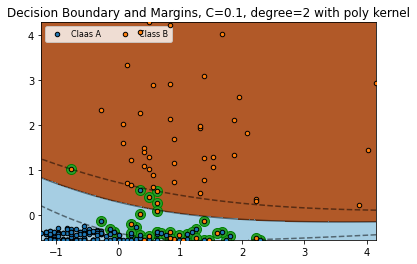

In [155]:
ploter.plot(X_train, y_train, model)

In [156]:
X = normalize(df[["title_len", "msPlayed"]].to_numpy(), mu, sig)

df["music"] = ~model.predict(X)

In [157]:
df[~df.music].sample(n=50)

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime,known_podcast,title_len,music
12040,2021-03-18 22:01:00,Nouvelle École,#23 - Bruno -Navo- Muschio : La chance respect...,2045333,0 days 00:34:05.333000,2021-03-18 21:26:54.667,False,70,False
7313,2021-02-01 23:45:00,Les Couilles sur la table,Les preuves de la virilité,1283715,0 days 00:21:23.715000,2021-02-01 23:23:36.285,False,27,False
16191,2021-04-27 19:25:00,Crac Crac,Sexe & Racisme,2555349,0 days 00:42:35.349000,2021-04-27 18:42:24.651,False,14,False
10578,2021-03-09 10:23:00,Ben Névert,"HARCÈLEMENT, HOMOSEXUALITÉ, EXCLUSION... - ENT...",640917,0 days 00:10:40.917000,2021-03-09 10:12:19.083,False,53,False
6562,2021-01-25 23:12:00,FloodCast,S06E06 - Donne ton sperme t'en as plein !,3550614,0 days 00:59:10.614000,2021-01-25 22:12:49.386,True,41,False
7329,2021-02-02 14:48:00,Un Bon Moment avec Kyan KHOJANDI et NAVO,avec FLORENT BERNARD et BAPTISTE LECAPLAIN,5208212,0 days 01:26:48.212000,2021-02-02 13:21:11.788,True,42,False
29578,2021-08-13 16:23:00,FloodCast,S06E15 - Le Maxi Best-Of de la Route des Vacan...,4542250,0 days 01:15:42.250000,2021-08-13 15:07:17.750,True,50,False
1513,2020-12-05 10:50:00,On réécrit,On réécrit...Justice League,1582748,0 days 00:26:22.748000,2020-12-05 10:23:37.252,False,27,False
40053,2021-11-13 12:04:00,FloodCast,S07E09 - Adri Toute la Tech,6603797,0 days 01:50:03.797000,2021-11-13 10:13:56.203,True,27,False
34216,2021-09-26 20:06:00,Pink Floyd,"Shine On You Crazy Diamond, Pts. 1-5 - 2011 Re...",811077,0 days 00:13:31.077000,2021-09-26 19:52:28.923,False,52,False


In [158]:
df = df[df.music]

In [159]:
df.head()

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime,known_podcast,title_len,music
0,2020-11-20 08:55:00,Rayland Baxter,Yellow Eyes,156074,0 days 00:02:36.074000,2020-11-20 08:52:23.926,False,11,True
2,2020-11-21 12:53:00,Peter Bjorn and John,Young Folks,4800,0 days 00:00:04.800000,2020-11-21 12:52:55.200,False,11,True
3,2020-11-21 12:53:00,alt-J,Breezeblocks,5290,0 days 00:00:05.290000,2020-11-21 12:52:54.710,False,12,True
4,2020-11-21 12:57:00,Bibio,lovers’ carvings,238640,0 days 00:03:58.640000,2020-11-21 12:53:01.360,False,16,True
5,2020-11-21 13:02:00,Fleet Foxes,Mykonos,275306,0 days 00:04:35.306000,2020-11-21 12:57:24.694,False,7,True


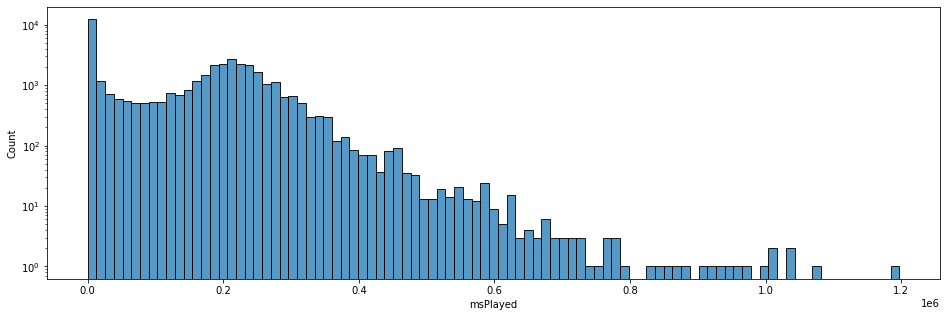

In [160]:
f = plt.figure(figsize=(16, 5))
g = sns.histplot(data=df, x="msPlayed")
g.set_yscale("log");

In [161]:
stats = ploter.CIs(data=df, columns=["msPlayed"], funcs=[np.mean])
stats["msPlayed"] = stats.msPlayed.apply(lambda x : pd.Timedelta(x, unit='ms'))
stats

,msPlayed
mean_low,0 days 00:02:19.535689367
mean_computed,0 days 00:02:20.626831654
mean_high,0 days 00:02:21.801765541


##### d) Unicity of entries 

In [162]:
df.head()

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime,known_podcast,title_len,music
0,2020-11-20 08:55:00,Rayland Baxter,Yellow Eyes,156074,0 days 00:02:36.074000,2020-11-20 08:52:23.926,False,11,True
2,2020-11-21 12:53:00,Peter Bjorn and John,Young Folks,4800,0 days 00:00:04.800000,2020-11-21 12:52:55.200,False,11,True
3,2020-11-21 12:53:00,alt-J,Breezeblocks,5290,0 days 00:00:05.290000,2020-11-21 12:52:54.710,False,12,True
4,2020-11-21 12:57:00,Bibio,lovers’ carvings,238640,0 days 00:03:58.640000,2020-11-21 12:53:01.360,False,16,True
5,2020-11-21 13:02:00,Fleet Foxes,Mykonos,275306,0 days 00:04:35.306000,2020-11-21 12:57:24.694,False,7,True


In [163]:
print(f"Total : {len(df.index)}, number of unique tracks : {len(np.unique(df.trackName))}")

Total : 41189, number of unique tracks : 7202


In [164]:
counts = pd.DataFrame(df.groupby("trackName").apply(len)).reset_index(drop=False)
counts = counts.rename(columns={0:"counts"})
df = pd.merge(df, counts, on="trackName")
df = df.sort_values(by="startTime")

In [165]:
df.head()

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime,known_podcast,title_len,music,counts
0,2020-11-20 08:55:00,Rayland Baxter,Yellow Eyes,156074,0 days 00:02:36.074000,2020-11-20 08:52:23.926,False,11,True,77
136,2020-11-21 12:53:00,alt-J,Breezeblocks,5290,0 days 00:00:05.290000,2020-11-21 12:52:54.710,False,12,True,60
77,2020-11-21 12:53:00,Peter Bjorn and John,Young Folks,4800,0 days 00:00:04.800000,2020-11-21 12:52:55.200,False,11,True,59
196,2020-11-21 12:57:00,Bibio,lovers’ carvings,238640,0 days 00:03:58.640000,2020-11-21 12:53:01.360,False,16,True,15
211,2020-11-21 13:02:00,Fleet Foxes,Mykonos,275306,0 days 00:04:35.306000,2020-11-21 12:57:24.694,False,7,True,52


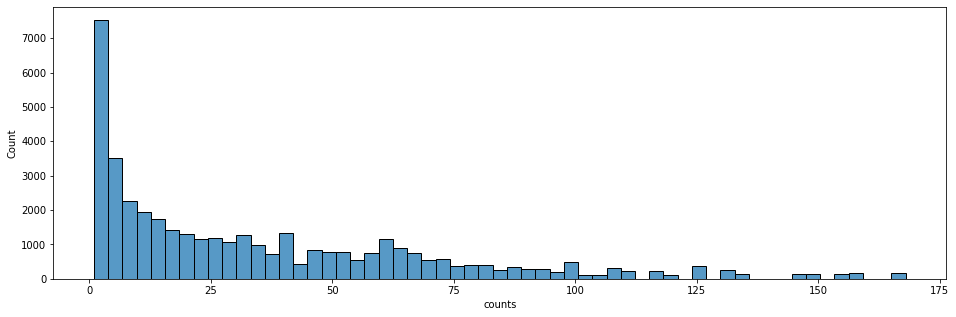

In [166]:
f = plt.figure(figsize=(16, 5))
sns.histplot(data=df, x="counts");

Most listen tunes : 

In [167]:
df.drop_duplicates("trackName").sort_values(by="counts").tail(n=10)

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime,known_podcast,title_len,music,counts
21661,2021-01-15 19:53:00,L'Impératrice,Sonate Pacifique,348944,0 days 00:05:48.944000,2021-01-15 19:47:11.056,False,16,True,126
6406,2020-11-27 11:07:00,The Voidz,Leave It In My Dreams,239441,0 days 00:03:59.441000,2020-11-27 11:03:00.559,False,21,True,126
5849,2020-11-26 16:05:00,Interpol,No I In Threesome,231533,0 days 00:03:51.533000,2020-11-26 16:01:08.467,False,17,True,131
17392,2021-01-02 09:05:00,Papooz,Ann Wants to Dance,210786,0 days 00:03:30.786000,2021-01-02 09:01:29.214,False,18,True,132
7306,2020-11-27 13:15:00,The Strokes,Under Cover of Darkness,235546,0 days 00:03:55.546000,2020-11-27 13:11:04.454,False,23,True,134
1628,2020-11-21 23:53:00,The Strokes,You Only Live Once,597,0 days 00:00:00.597000,2020-11-21 23:52:59.403,False,18,True,147
6599,2020-11-27 11:17:00,Broken Bells,The High Road,232200,0 days 00:03:52.200000,2020-11-27 11:13:07.800,False,13,True,150
355,2020-11-21 13:33:00,Real Estate,It's Real,168493,0 days 00:02:48.493000,2020-11-21 13:30:11.507,False,9,True,154
6898,2020-11-27 13:02:00,Interpol,Rest My Chemistry,301093,0 days 00:05:01.093000,2020-11-27 12:56:58.907,False,17,True,158
7138,2020-11-27 13:11:00,Metronomy,The Look,277653,0 days 00:04:37.653000,2020-11-27 13:06:22.347,False,8,True,168


Let's see with artists : Are you a stan?

In [168]:
artistCounts = pd.DataFrame(df.groupby("artistName").apply(len)).reset_index(drop=False)
artistCounts = artistCounts.rename(columns={0:"counts"})

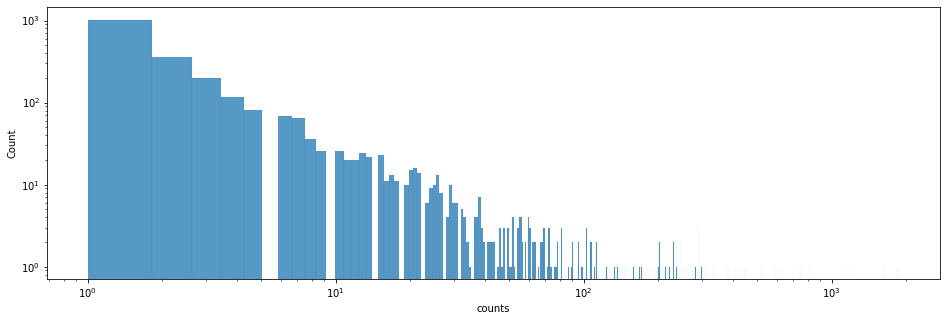

In [169]:
f = plt.figure(figsize=(16, 5))
g = sns.histplot(data=artistCounts, x="counts")
g.set_yscale("log")
g.set_xscale("log");
### lol it's a log log plot you're dangerous

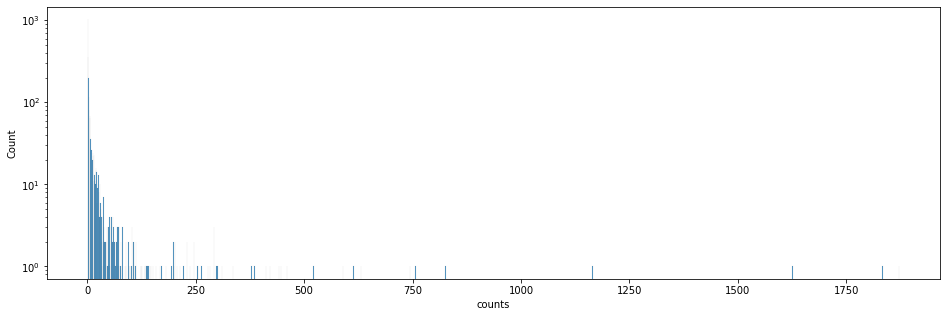

In [170]:
f = plt.figure(figsize=(16, 5))
g = sns.histplot(data=artistCounts, x="counts")
g.set_yscale("log")

What are those max values :

In [171]:
artistCounts.sort_values(by="counts", ascending=False).head(n=15)

,artistName,counts
2190,The Strokes,1872
114,Arctic Monkeys,1833
963,Interpol,1626
1685,Phoenix,1165
1756,Real Estate,826
1628,Papooz,757
2124,The Kooks,744
1631,Parcels,631
1758,Red Hot Chili Peppers,614
75,Alvvays,590


Examples of artists you've listened only once :

In [172]:
artistCounts[artistCounts.counts == 1].sample(n=10)

,artistName,counts
935,Hypnolove,1
2143,The Modern Lovers,1
2460,shame,1
2117,The Juan Maclean,1
1379,Marlena Shaw,1
1920,Soft Cell,1
1769,Reverend And The Makers,1
2357,What After This?,1
381,Charming Horses,1
2252,Tony Anderson,1


In [175]:
artistCounts = artistCounts.rename(columns={'counts':"artist_count"})

In [177]:
df = df.merge(artistCounts, on="artistName")
df = df.rename(columns={"counts":"tune_count"})

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime,known_podcast,title_len,music,tune_count,artist_count
0,2020-11-20 08:55:00,Rayland Baxter,Yellow Eyes,156074,0 days 00:02:36.074000,2020-11-20 08:52:23.926,False,11,True,77,136
1,2020-11-21 23:49:00,Rayland Baxter,Yellow Eyes,230786,0 days 00:03:50.786000,2020-11-21 23:45:09.214,False,11,True,77,136
2,2020-11-23 20:04:00,Rayland Baxter,Yellow Eyes,230786,0 days 00:03:50.786000,2020-11-23 20:00:09.214,False,11,True,77,136
3,2020-11-26 08:54:00,Rayland Baxter,Yellow Eyes,230786,0 days 00:03:50.786000,2020-11-26 08:50:09.214,False,11,True,77,136
4,2020-11-26 10:42:00,Rayland Baxter,Yellow Eyes,230786,0 days 00:03:50.786000,2020-11-26 10:38:09.214,False,11,True,77,136
...,...,...,...,...,...,...,...,...,...,...,...
41184,2021-11-19 16:21:00,Ancient Astronauts,I Came Running,15557,0 days 00:00:15.557000,2021-11-19 16:20:44.443,False,14,True,1,1
41185,2021-11-19 17:11:00,Damon Albarn,The Selfish Giant,55810,0 days 00:00:55.810000,2021-11-19 17:10:04.190,False,17,True,2,2
41186,2021-11-19 17:16:00,Damon Albarn,The Selfish Giant,53647,0 days 00:00:53.647000,2021-11-19 17:15:06.353,False,17,True,2,2
41187,2021-11-19 17:47:00,John Vincent III,Next to You,256520,0 days 00:04:16.520000,2021-11-19 17:42:43.480,False,11,True,1,1


In [178]:
df = df.sort_values(by="startTime")

In [179]:
df.head()

,endTime,artistName,trackName,msPlayed,msPlayedDate,startTime,known_podcast,title_len,music,tune_count,artist_count
0,2020-11-20 08:55:00,Rayland Baxter,Yellow Eyes,156074,0 days 00:02:36.074000,2020-11-20 08:52:23.926,False,11,True,77,136
136,2020-11-21 12:53:00,alt-J,Breezeblocks,5290,0 days 00:00:05.290000,2020-11-21 12:52:54.710,False,12,True,60,442
578,2020-11-21 12:53:00,Peter Bjorn and John,Young Folks,4800,0 days 00:00:04.800000,2020-11-21 12:52:55.200,False,11,True,59,70
648,2020-11-21 12:57:00,Bibio,lovers’ carvings,238640,0 days 00:03:58.640000,2020-11-21 12:53:01.360,False,16,True,15,18
666,2020-11-21 13:02:00,Fleet Foxes,Mykonos,275306,0 days 00:04:35.306000,2020-11-21 12:57:24.694,False,7,True,52,60


Correlation Artist count/ track count ?

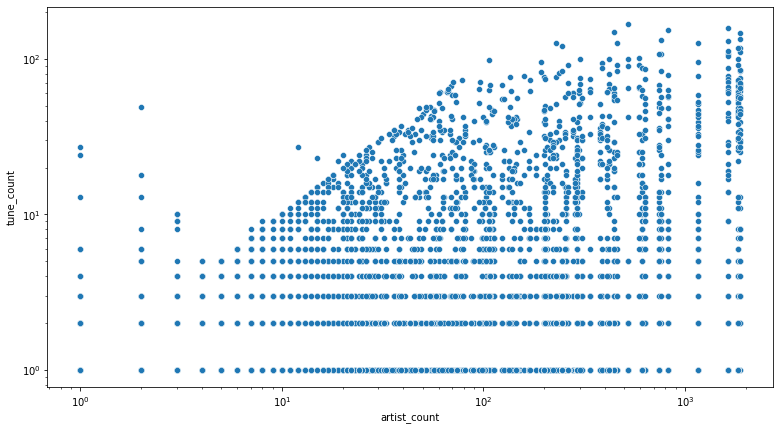

In [185]:
f = plt.figure(figsize=(13, 7))
g = sns.scatterplot(data=df.drop_duplicates("trackName"), x="artist_count", y="tune_count")
g.set_yscale("log")
g.set_xscale("log");

A typical day : 

In [237]:
def get_season(date):
    month = date.month
    day = date.day
    if(month == 1 or month == 2 or (month == 12 and day > 20) or (month == 3 and day < 20)):
        return "Winter"
    elif ((month == 3 and day > 20) or (month == 4) or (month == 5) or (month == 6 and day < 20)):
        return "Spring"
    elif ((month == 6 and day > 20) or (month == 7) or (month == 8) or (month == 9 and day < 20)):
        return "Summer"
    else :
          return "Fall"

In [238]:
df["daytime"] = df.startTime.apply(lambda x : datetime(year=2021, month=1, day=1, hour=x.hour, minute=x.minute, second=x.second))
df["season"] = df.startTime.apply(get_season)

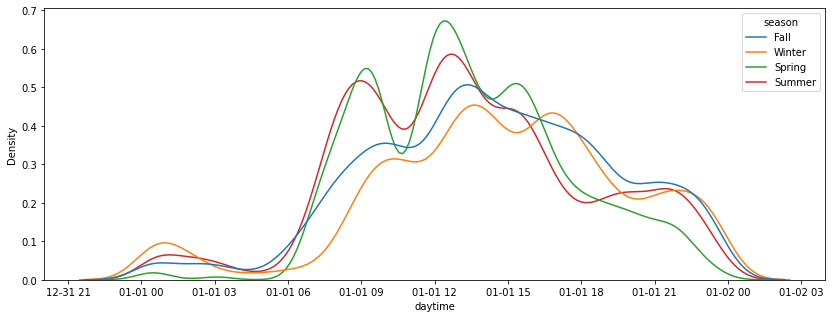

In [239]:
f, a = plt.subplots(figsize=(14, 5))
sns.kdeplot(data=df, x="daytime", hue="season");

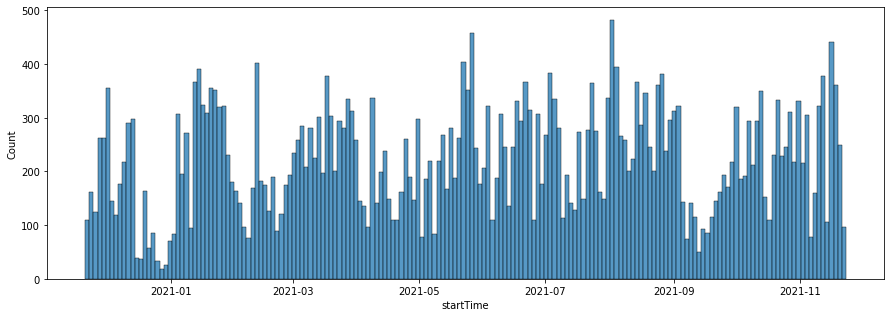

In [202]:
f = plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="startTime", binwidth=2);